In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error, roc_curve, auc

The goal here is to determine the relationship between medical costs and other information about a person. I'm using a dataset from Kaggle for the project. My assumptions before diving in are that there will be a strong correlation between cost and things like bmi and smoking status, but that extreme outliers will exists that need to be accounted for. This is the kind of data the insurance companies use to determine premiums. The more accurate the prediction, the lower the price of health insurance can be.

In [2]:
df = pd.read_csv('files/medical_insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


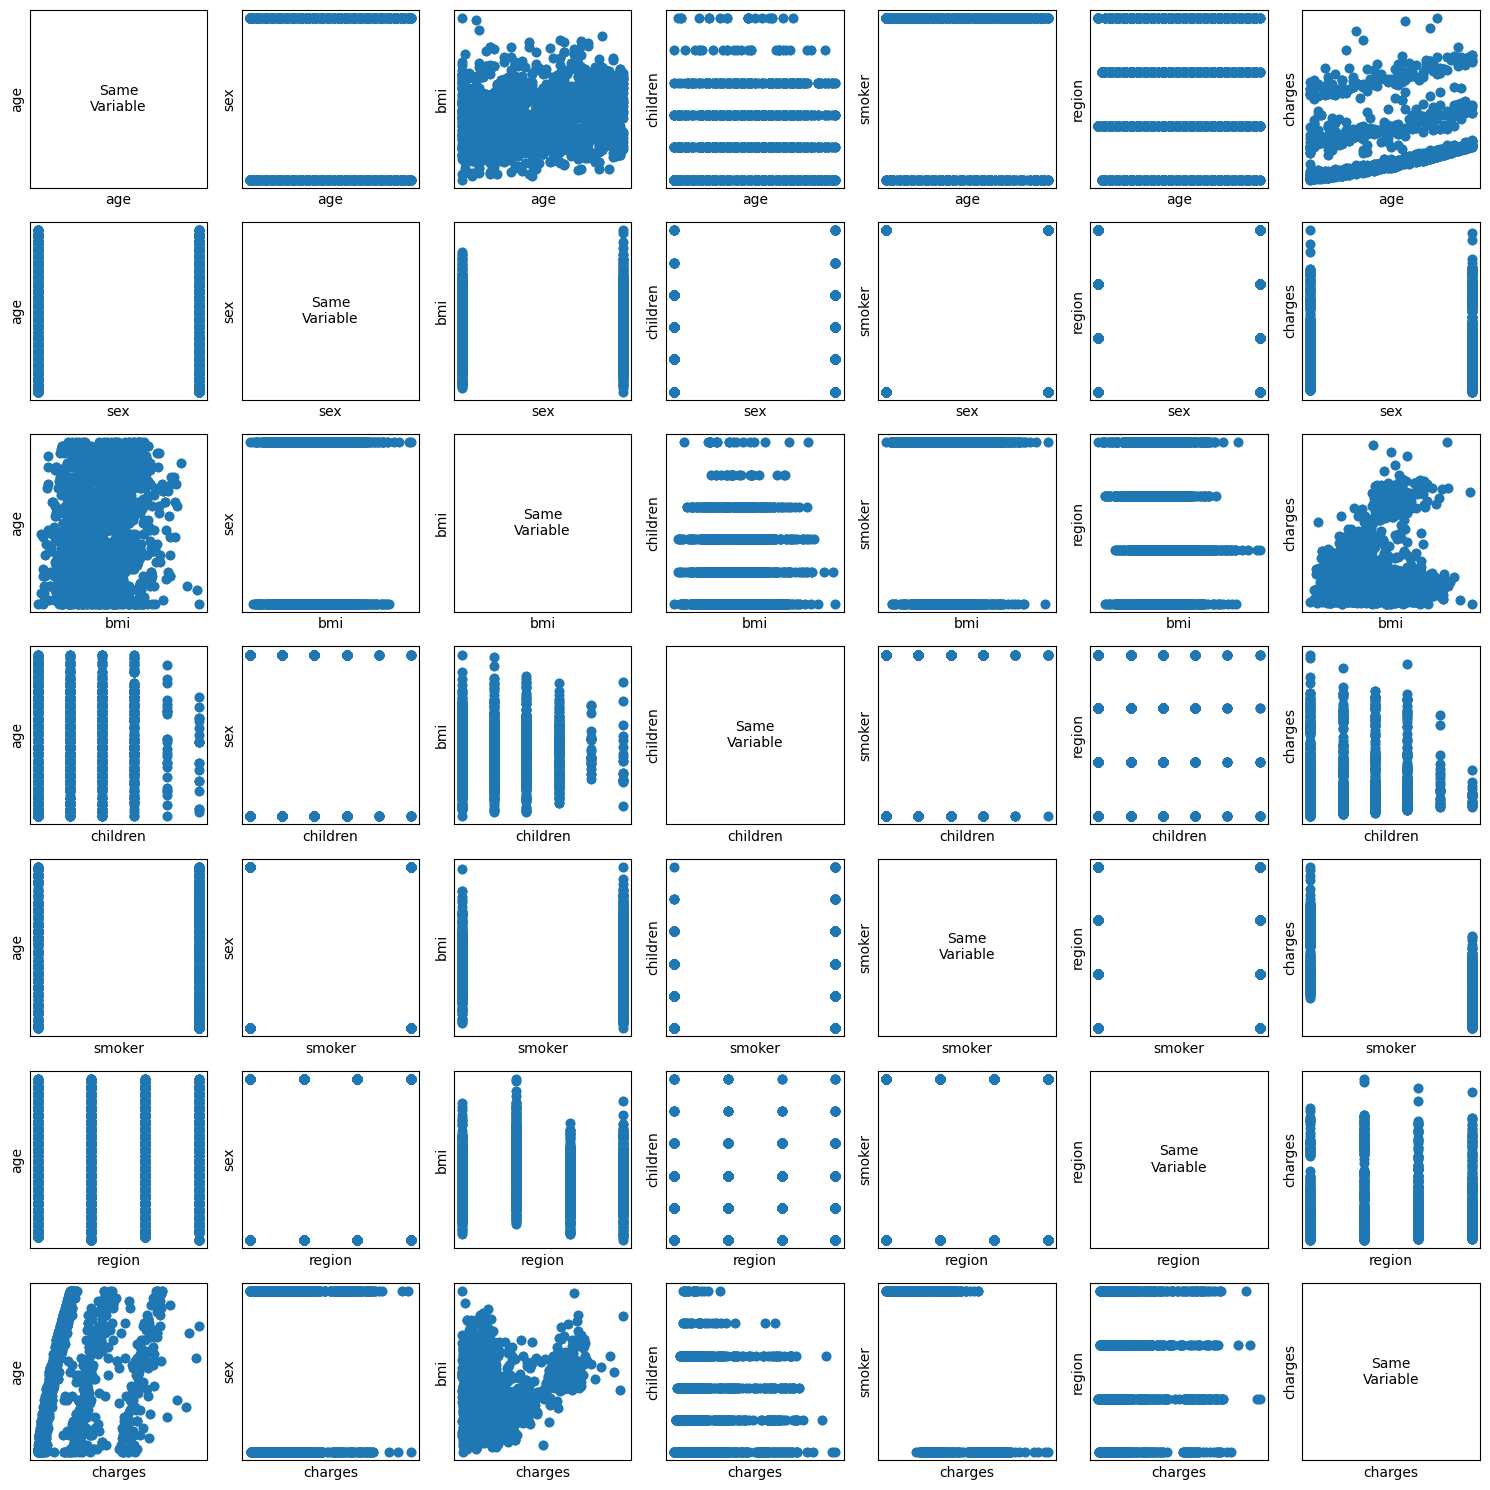

In [3]:
columns = df.columns
n = len(columns)

fig, axs = plt.subplots(n, n, figsize=(15, 15))  # Adjust the figure size as needed

for i in range(n):
    for j in range(n):
        if i != j:
            axs[i, j].scatter(df[columns[i]], df[columns[j]])
            axs[i, j].set_xlabel(columns[i])
            axs[i, j].set_ylabel(columns[j])
        else:
            axs[i, j].text(0.5, 0.5, 'Same\nVariable', horizontalalignment='center', verticalalignment='center')
            axs[i, j].set_xlabel(columns[i])
            axs[i, j].set_ylabel(columns[j])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.tight_layout()
plt.show()

Plotting the variables against each other individually to get a good idea of their relationships. Some things to notice - some strange striping in the age but that charges generally go up with age. Most of the high charges also have high bmi but plenty of high bmi have low charges. Smoking seems like a solid indicator with some overlap in the middle but mostly separable. People with more children tend to have neither extremely high nor low bmi's.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [5]:
df_categories = pd.concat([df, pd.get_dummies(df[['sex', 'smoker', 'region']])], axis=1).drop(columns=['sex', 'smoker', 'region'])
df_categories.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,True,False,False,True,False,False,False,True
1,18,33.770,1,1725.55230,False,True,True,False,False,False,True,False
2,28,33.000,3,4449.46200,False,True,True,False,False,False,True,False
3,33,22.705,0,21984.47061,False,True,True,False,False,True,False,False
4,32,28.880,0,3866.85520,False,True,True,False,False,True,False,False


In [6]:
df_categories.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


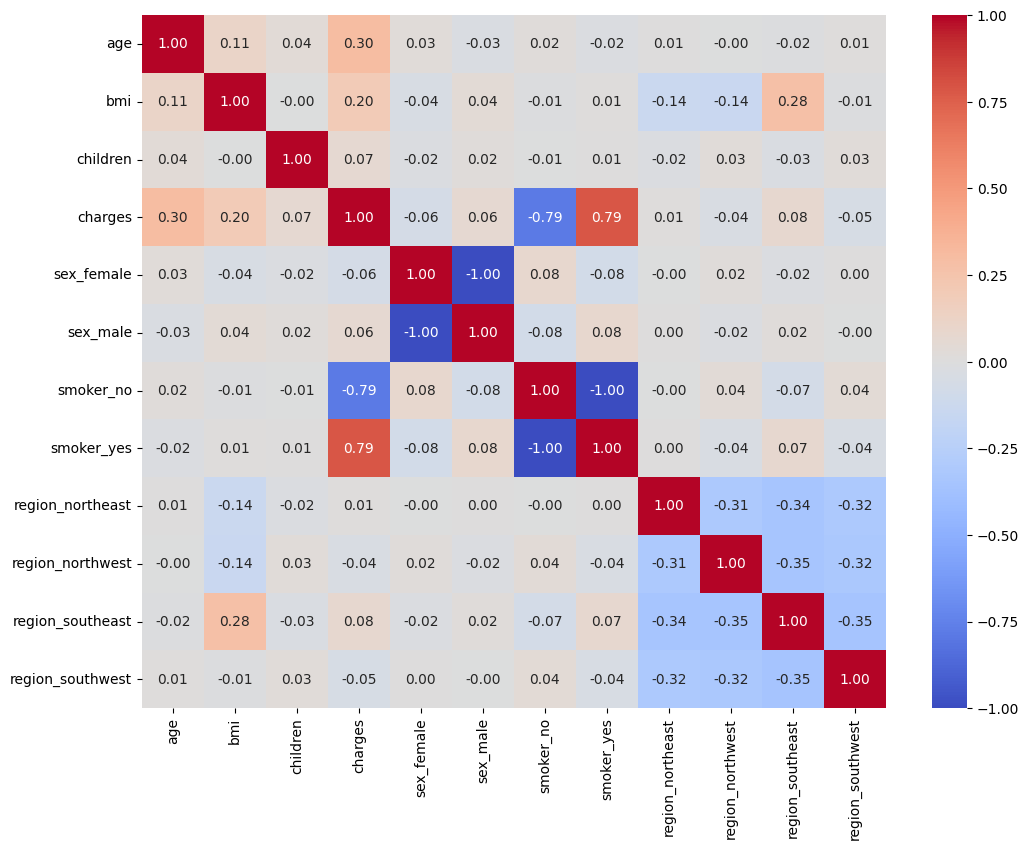

In [7]:
plt.figure(figsize=(12,9))
sns.heatmap(df_categories.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

it looks like age, smoking status, and bmi have the largest impact on charges, which is expected. Interesting that region carries as large of a swing as it does, I wonder if that is noise or not.

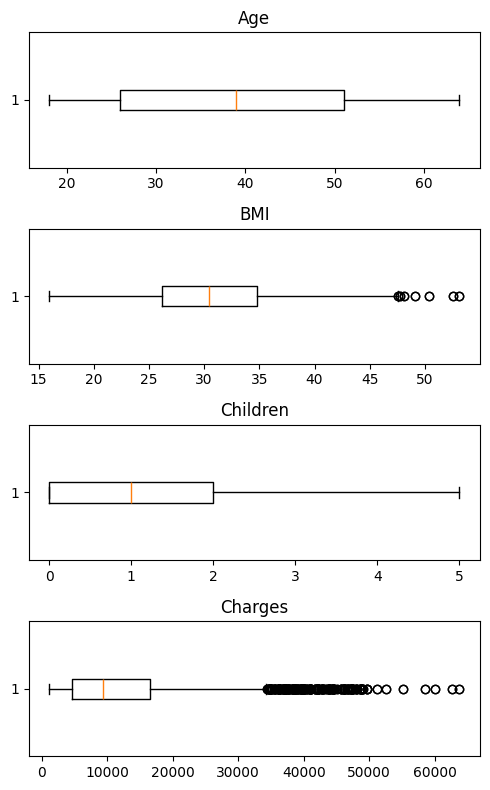

In [8]:
fig, axs = plt.subplots(4, figsize=(5,8))

axs[0].boxplot(df_categories['age'], vert=False)
axs[0].set_title('Age')

axs[1].boxplot(df_categories['bmi'], vert=False)
axs[1].set_title('BMI')

axs[2].boxplot(df_categories['children'], vert=False)
axs[2].set_title('Children')

axs[3].boxplot(df_categories['charges'], vert=False)
axs[3].set_title('Charges')

plt.tight_layout()

plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error, roc_curve, auc

In [10]:
categorical_features = ['sex', 'smoker', 'region']
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder="passthrough")
X_transformed = transformer.fit_transform(df.drop('charges', axis=1))
y = df['charges']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.15, random_state=42)

We're evaluating a number of different model types and comparing validation results before choosing the one that we'll settle on in the end.

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "Gradient Boosting Regression": GradientBoostingRegressor(),
}

In [15]:
print("Regression Models Evaluation:\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2_score_model = r2_score(y_test, predictions)
    mse_score = mean_squared_error(y_test, predictions)
    mae_score = mean_absolute_error(y_test, predictions)

    print(name)
    print(f"R2 {r2_score_model}")
    print(f"MSE {mse_score}")
    print(f"MAE {mae_score}\n")

Regression Models Evaluation:

Linear Regression
R2 0.7441812278943364
MSE 38012307.503251255
MAE 4094.4702897522297

Ridge Regression
R2 0.7441472661644895
MSE 38017353.9027303
MAE 4096.716239411772

Decision Tree Regression
R2 0.9576114677146694
MSE 6298544.514848783
MAE 477.18793939903844

Random Forest Regression
R2 0.9416288750169777
MSE 8673410.218890782
MAE 1293.6566380636057

Gradient Boosting Regression
R2 0.871468612272795
MSE 19098577.457357593
MAE 2313.151845340984



Decisions tree and random forest coming out on top. I think this makes sense with the categorical data resulting in vastly different impacts from the other variables. Ie, a smoker might have a completely different relationship with age and weight than a non-smoker. We're going to convert charges into a category (either above or below the median) and try the same process over with different models to see if better results are given.

In [16]:
df['charges_category'] = (df['charges'] > df['charges'].median()).astype(int)
y_categorical = df['charges_category']
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_transformed, y_categorical, test_size=0.15, random_state=42)

In [17]:
class_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN Classification": KNeighborsClassifier(),
    "SVM Classification": SVC(probability=True),
    "Naive Bayes Classification": GaussianNB()
}

In [19]:
print("Classification Models Evaluation:\n")
for name, model in class_models.items():
    model.fit(X_train_cat, y_train_cat)
    if name == "SVM Classification":
        predictions = model.decision_function(X_test_cat)
    else:
        predictions = model.predict_proba(X_test_cat)[:, 1]
    accuracy = accuracy_score(y_test_cat, model.predict(X_test_cat))
    print(f"{name}: Accuracy = {accuracy:.2f}")

Classification Models Evaluation:

Logistic Regression: Accuracy = 0.90
KNN Classification: Accuracy = 0.86
SVM Classification: Accuracy = 0.81
Naive Bayes Classification: Accuracy = 0.69


I would say that between all the tested models, the decision tree performed best and will go with that moving forward.